Basic Imports for Pytorch

In [ ]:
# Importing required libraries
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time

/ext3/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Defining helper functions


1.   Progress Bar: To help with verbose training information and progress visualization.
2.   Cutout: A regularization tool to help with augmentation, as proposed by DeVries and Taylor (2017), https://arxiv.org/pdf/1708.04552.pdf



In [ ]:
import sys
import numpy as np
from PIL import Image


class ProgressBar:

    def __init__(self, width=30):
        self.width = width

    def update(self, max_value, current_value, info):
        progress = int(round(self.width * current_value / max_value))
        bar = '=' * progress + '.' * (self.width - progress)
        prefix = '{}/{}'.format(current_value, max_value)

        prefix_max_len = len('{}/{}'.format(max_value, max_value))
        buffer = ' ' * (prefix_max_len - len(prefix))

        sys.stdout.write('\r {} {} [{}] - {}'.format(prefix, buffer, bar, info))
        sys.stdout.flush()

    def new_line(self):
        print()

# Cutout basically covers a region of an input image. Its a data augmentation technique
class Cutout(object):
    def __init__(self, num_cutouts, size, p=0.5):
        self.num_cutouts = num_cutouts
        self.size = size
        self.p = p

    def __call__(self, img):

        height, width = img.size

        cutouts = np.ones((height, width))

        if np.random.uniform() < 1 - self.p:
            return img

        for i in range(self.num_cutouts):
            y_center = np.random.randint(0, height)
            x_center = np.random.randint(0, width)

            y1 = np.clip(y_center - self.size // 2, 0, height)
            y2 = np.clip(y_center + self.size // 2, 0, height)
            x1 = np.clip(x_center - self.size // 2, 0, width)
            x2 = np.clip(x_center + self.size // 2, 0, width)

            cutouts[y1:y2, x1:x2] = 0

        cutouts = np.broadcast_to(cutouts, (3, height, width))
        cutouts = np.moveaxis(cutouts, 0, 2)
        img = np.array(img)
        img = img * cutouts
        return Image.fromarray(img.astype('uint8'), 'RGB')

# Loading the CIFAR-10 dataset.
## Additionally defining Augmentation Transformations for it and Normalizing the data.

In [ ]:
# Configuring parameters given by wandb.ai for cutout
train_transform = transforms.Compose([
            Cutout(num_cutouts=2, size=8, p=0.8),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                             ])
# train and test dataset
train_dataset = datasets.CIFAR10('data/cifar', train=True, download=True, transform=train_transform)

test_dataset = datasets.CIFAR10('data/cifar', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


## Test Function to test the model

In [ ]:
def test(model, criterion, batch_size=512):
        model.eval()
        test_loss = 0
        
        data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in enumerate(data_loader, 0):
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)  # Calculate loss
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels.flatten()).sum().item()

        model.train()
        
        return correct / total, test_loss

Helper Function to build the optimizer:

In [ ]:
# we shall use sgd and adam optimizer
def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer
# we shall use sgd and adam optimizer
def build_optimizer_w_decay(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9, weight_decay=1e-5)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate, weight_decay=1e-5)
    return optimizer

# Model Definition for hyperparameter sweep.

This is a modified ResNet model, with the architecture shown below.

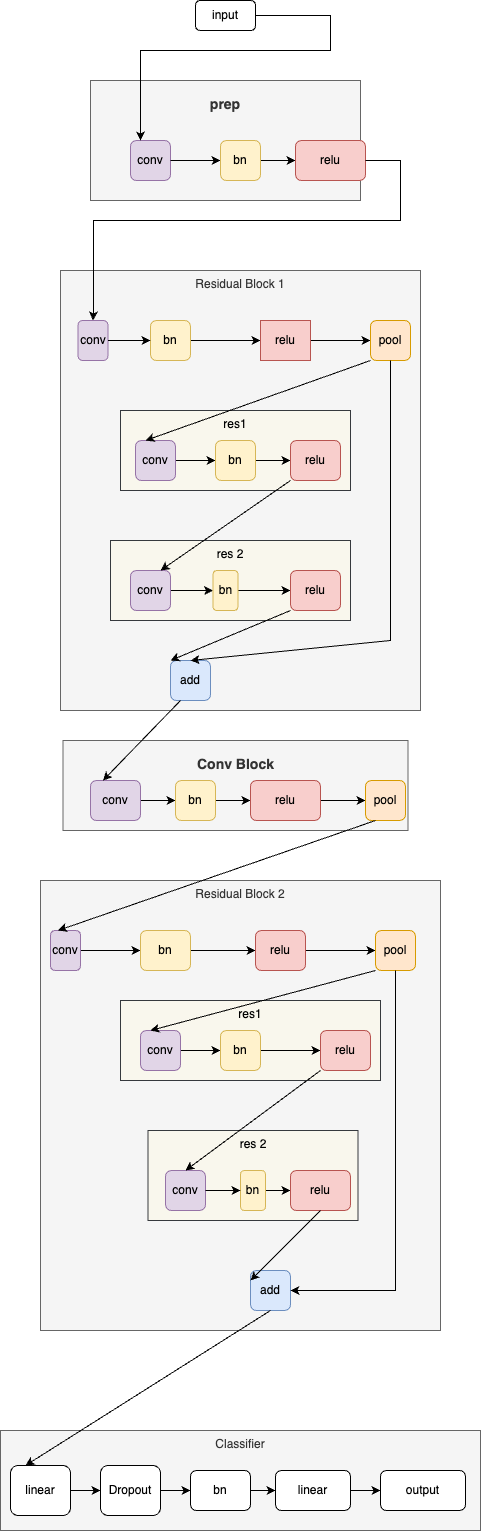

In [ ]:
# Basic block are labeled in the diagram as res1 and res 2
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out

# Modified ResNet9 Network
class ResNet9(nn.Module):
    def __init__(self, activation='relu', fc_size=1024, dropout=0.5):
        super(ResNet9, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.ReLU(inplace=True),
            # These 4 lines of code are the first subpart of residual block 1
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(inplace=True),
            # This pooling layer will have a skipped connection to the end
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Basic block are res 1 and res 2 combined 
            BasicBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            # This ends the first residual block
            # The next 4 lines of code are conv block
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # These last lines are residual block 2 as labeled in the architecture diagram
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            BasicBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # classifier block
        if activation == "relu":
            self.fc = nn.Sequential(
                nn.Linear(in_features=1024, out_features=fc_size, bias=True),
                nn.Dropout(p=dropout),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(num_features=fc_size, momentum=0.9),
                nn.Linear(in_features=fc_size, out_features=10, bias=True)
            )
        elif activation == "sigmoid":
            self.fc = nn.Sequential(
                nn.Linear(in_features=1024, out_features=fc_size, bias=True),
                nn.Dropout(p=dropout),
                nn.Sigmoid(),
                nn.BatchNorm1d(num_features=fc_size, momentum=0.9),
                nn.Linear(in_features=fc_size, out_features=10, bias=True)
            )
        
    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, out.shape[1] * out.shape[2] * out.shape[3])
        out = self.fc(out)
        return out

Training the network with the best params as per wandb.

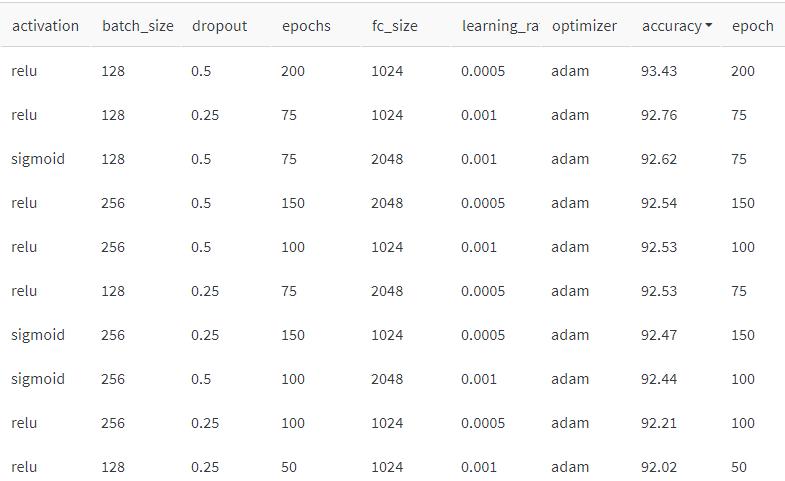

In [ ]:
def train(activation="relu", fc_size=1024, dropout=0.5, optimizer="adam", learning_rate=0.0005, epochs=200, batch_size=128):
    training_loss = []
    training_acc = []
    test_loss = []
    test_acc = []
    model = ResNet9(activation=activation, fc_size=fc_size, dropout=dropout).to(device)
    print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = build_optimizer(model, optimizer, learning_rate)
    model.train()
    criterion = nn.CrossEntropyLoss()
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
    best_accuracy=0
    progress_bar = ProgressBar()

    for epoch in range(1, epochs + 1):
        print('Epoch {}/{}'.format(epoch,epochs))
        running_loss = 0
        epoch_correct = 0
        epoch_total = 0
        for i, (inputs, targets) in enumerate(trainloader):

            inputs, targets = inputs.to(device), targets.to(device)

            # parameter gradients -> Zero
            optimizer.zero_grad()

            # Forward + backward + optimizer
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            batch_total = targets.size(0)
            batch_correct = predicted.eq(targets).sum().item()


            epoch_total += batch_total
            epoch_correct += batch_correct


            info_str = 'Last batch accuracy: {:.4f} - Running epoch accuracy {:.4f}'.\
                        format(batch_correct / batch_total, epoch_correct / epoch_total)
            progress_bar.update(max_value=len(trainloader), current_value=i, info=info_str)

        progress_bar.new_line()
        t_acc, t_loss = test(model, criterion)
        test_loss.append(t_loss)
        test_acc.append(t_acc*100)
        if epoch > epochs/2 and t_acc>best_accuracy:
            torch.save(model.state_dict(), "best_model.pth")
            best_accuracy=t_acc
        training_loss.append(running_loss)
        training_acc.append(epoch_correct / epoch_total * 100)
        print('Test accuracy: {:.2f}% Training Loss: {:.4f}'.format(t_acc*100,running_loss))
    print('Best accuracy: {:.2f}%'.format(best_accuracy*100))
    return training_loss, training_acc, test_loss, test_acc

In [ ]:
%%time 
activation="relu"
fc_size=1024
dropout=0.5
optimizer="adam"
learning_rate=0.0005
epochs=200
batch_size=128
training_loss,training_acc, test_loss, test_acc = train(activation, fc_size, dropout, optimizer, learning_rate, epochs, batch_size)

Number of trainable parameters: 3499594
Epoch 1/200
 390/391  [==============================] - Last batch accuracy: 0.5500 - Running epoch accuracy 0.4494
Test accuracy: 60.48% Training Loss: 585.9449
Epoch 2/200
 390/391  [==============================] - Last batch accuracy: 0.6000 - Running epoch accuracy 0.6353
Test accuracy: 68.00% Training Loss: 400.7067
Epoch 3/200
 390/391  [==============================] - Last batch accuracy: 0.7625 - Running epoch accuracy 0.7054
Test accuracy: 75.26% Training Loss: 331.7621
Epoch 4/200
 390/391  [==============================] - Last batch accuracy: 0.7000 - Running epoch accuracy 0.7442
Test accuracy: 76.33% Training Loss: 287.5297
Epoch 5/200
 390/391  [==============================] - Last batch accuracy: 0.7875 - Running epoch accuracy 0.7711
Test accuracy: 79.74% Training Loss: 260.5357
Epoch 6/200
 390/391  [==============================] - Last batch accuracy: 0.7625 - Running epoch accuracy 0.7927
Test accuracy: 81.21% Traini

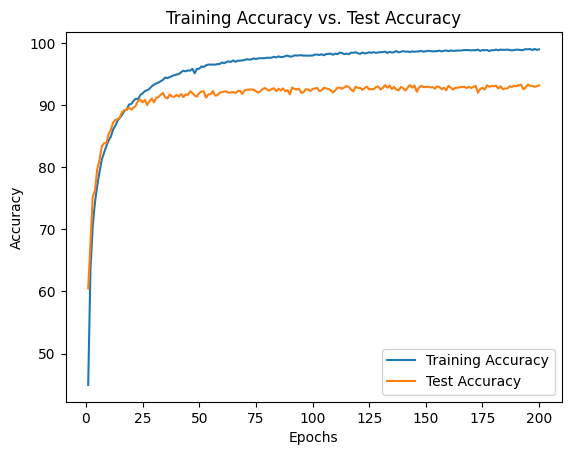

In [ ]:
import matplotlib.pyplot as plt

# Generate x-axis values (e.g., epochs or iterations)
epochs = len(training_acc)
x = list(range(1, epochs + 1))

# Plot training accuracy
plt.plot(x, training_acc, label='Training Accuracy')

# Plot test accuracy
plt.plot(x, test_acc, label='Test Accuracy')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Test Accuracy')
plt.legend()

# Show the plot
plt.show()


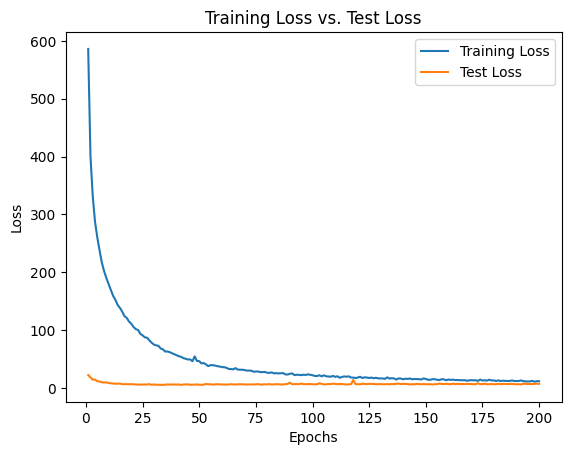

In [ ]:
# Generate x-axis values (e.g., epochs or iterations)
epochs = len(training_loss)
x = list(range(1, epochs + 1))

# Plot training loss
plt.plot(x, training_loss, label='Training Loss')

# Plot test loss
plt.plot(x, test_loss, label='Test Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Test Loss')
plt.legend()

# Show the plot
plt.show()

### Forcing the model to converge with a lower learning rate

In [ ]:
def train_best_model(activation="relu", fc_size=1024, dropout=0.5, optimizer="adam", learning_rate=0.0001, epochs=100, batch_size=128):
    
    model = ResNet9(activation=activation, fc_size=fc_size, dropout=dropout).to(device)
    model.load_state_dict(torch.load('best_model.pth'))
    training_loss = []
    training_acc = []
    test_loss = []
    test_acc = []
    print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = build_optimizer_w_decay(model, optimizer, learning_rate)
    model.train()
    criterion = nn.CrossEntropyLoss()
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
    best_accuracy=0
    progress_bar = ProgressBar()

    for epoch in range(1, epochs + 1):
        print('Epoch {}/{}'.format(epoch,epochs))
        running_loss = 0
        epoch_correct = 0
        epoch_total = 0
        for i, (inputs, targets) in enumerate(trainloader):

            inputs, targets = inputs.to(device), targets.to(device)

            # parameter gradients -> Zero
            optimizer.zero_grad()

            # Forward + backward + optimizer
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            batch_total = targets.size(0)
            batch_correct = predicted.eq(targets).sum().item()


            epoch_total += batch_total
            epoch_correct += batch_correct


            info_str = 'Last batch accuracy: {:.4f} - Running epoch accuracy {:.4f}'.\
                        format(batch_correct / batch_total, epoch_correct / epoch_total)
            progress_bar.update(max_value=len(trainloader), current_value=i, info=info_str)

        progress_bar.new_line()
        t_acc, t_loss = test(model, criterion)
        test_loss.append(t_loss)
        test_acc.append(t_acc*100)
        if t_acc>best_accuracy:
            torch.save(model.state_dict(), "best_model_conv.pth")
            best_accuracy=t_acc
        training_loss.append(running_loss)
        training_acc.append(epoch_correct / epoch_total * 100)
        print('Test accuracy: {:.2f}% Training Loss: {:.4f}'.format(t_acc*100,running_loss))
    print('Best accuracy: {:.2f}%'.format(best_accuracy*100))
    return training_loss, training_acc, test_loss, test_acc  
     

In [ ]:
%%time
learning_rate=0.0001
epochs=100
training_loss, training_acc, test_loss, test_acc = train_best_model(learning_rate=0.0001)   

Number of trainable parameters: 3499594
Epoch 1/100
 390/391  [==============================] - Last batch accuracy: 1.0000 - Running epoch accuracy 0.9931
Test accuracy: 93.42% Training Loss: 8.0363
Epoch 2/100
 390/391  [==============================] - Last batch accuracy: 1.0000 - Running epoch accuracy 0.9940
Test accuracy: 93.69% Training Loss: 7.0014
Epoch 3/100
 390/391  [==============================] - Last batch accuracy: 1.0000 - Running epoch accuracy 0.9948
Test accuracy: 93.64% Training Loss: 6.3434
Epoch 4/100
 390/391  [==============================] - Last batch accuracy: 0.9875 - Running epoch accuracy 0.9951
Test accuracy: 93.71% Training Loss: 6.2145
Epoch 5/100
 390/391  [==============================] - Last batch accuracy: 0.9875 - Running epoch accuracy 0.9950
Test accuracy: 93.88% Training Loss: 5.8384
Epoch 6/100
 390/391  [==============================] - Last batch accuracy: 1.0000 - Running epoch accuracy 0.9948
Test accuracy: 93.89% Training Loss: 5

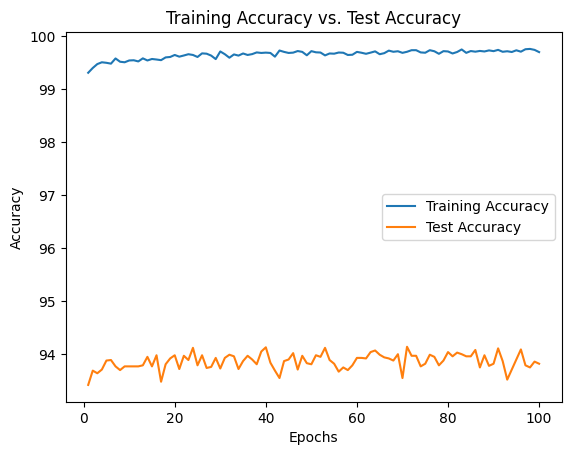

In [ ]:
import matplotlib.pyplot as plt

# Generate x-axis values (e.g., epochs or iterations)
epochs = len(training_acc)
x = list(range(1, epochs + 1))

# Plot training accuracy
plt.plot(x, training_acc, label='Training Accuracy')

# Plot test accuracy
plt.plot(x, test_acc, label='Test Accuracy')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Test Accuracy')
plt.legend()

# Show the plot
plt.show()


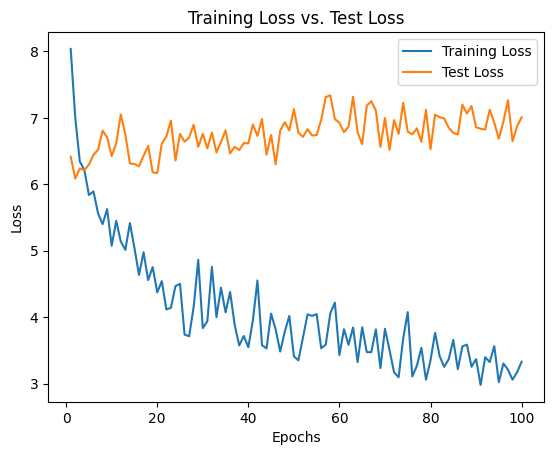

In [ ]:
# Generate x-axis values (e.g., epochs or iterations)
epochs = len(training_loss)
x = list(range(1, epochs + 1))

# Plot training loss
plt.plot(x, training_loss, label='Training Loss')

# Plot test loss
plt.plot(x, test_loss, label='Test Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Test Loss')
plt.legend()

# Show the plot
plt.show()

# Final Accuracy:

In [ ]:
print("Top training Accuracy: {:.2f}%".format(max(training_acc)))

Top training Accuracy: 99.76%


In [ ]:
print("Final Model with best Test Accuracy: {:.2f}%".format(max(test_acc)))

Final Model with best Accuracy: 94.14%


# Model Summary

In [ ]:
from torchsummary import summary
model = ResNet9(activation="relu", fc_size=1024, dropout=0.5).to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,